# Association Rule Mining for Error Detection in Predictive Models

This notebook demonstrates an example of our approach that is described fully in the pdf.

**Our solution:**
1. Train a base model (XGBoost classifier)
2. Identify prediction errors on training data
3. Mine association rules to identify patterns in errors
4. Apply these rules to correct predictions on test data
5. Evaluate the corrected model performance

We'll use the Heart Disease dataset from UCI for this demonstration.

## 0. install packages

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")

## 2. Functions for Data Preparation and Rule Mining

In [4]:
def prepare_data_for_rule_mining(data):
    """
    Prepare data for association rule mining by discretizing numerical features
    and formatting categorical features appropriately.

    Creates a value_to_column mapping to track which column each value came from.

    Returns:
        tuple: (list of transactions, value_to_column_mapping)
    """
    prepared_data = data.copy()

    # Create a mapping dictionary to track which column each value belongs to
    value_to_column = {}

    # Process columns in a deterministic order to ensure consistent mapping
    sorted_columns = sorted(prepared_data.columns)

    # First pass: Process all categorical columns
    for col in sorted_columns:
        if (
            prepared_data[col].dtype == "object"
            or prepared_data[col].dtype.name == "category"
        ):
            # Get unique values
            unique_values = prepared_data[col].dropna().unique()

            # Add mappings for both formats (with and without column prefix)
            for val in unique_values:
                item_name = f"{col}_{val}"
                # Store with column prefix
                value_to_column[item_name] = col

                # Only store raw value if it's not a simple number
                # This avoids ambiguity with bin numbers
                if not str(val).isdigit() and not isinstance(val, (int, float)):
                    value_to_column[str(val)] = col

            # Apply transformation
            prepared_data[col] = prepared_data[col].apply(
                lambda x: f"{col}_{x}" if pd.notnull(x) else np.nan
            )

    # Second pass: Process all numerical columns
    for col in sorted_columns:
        if (
            prepared_data[col].dtype in ["int64", "float64"]
            and col in prepared_data.columns
        ):
            # Skip columns with too few unique values or all same value
            if prepared_data[col].nunique() <= 1 or prepared_data[col].std() == 0:
                # For single-value columns, use a special format
                unique_values = prepared_data[col].unique()
                for val in unique_values:
                    item_name = f"{col}_{val}"
                    value_to_column[item_name] = col
                    # DO NOT add the raw value mapping to avoid ambiguity

                prepared_data[col] = prepared_data[col].apply(lambda x: f"{col}_{x}")
                continue

            try:
                # Discretize using quantiles - store the bin mapping
                binned_values = pd.qcut(
                    prepared_data[col], q=4, labels=False, duplicates="drop"
                )

                # Create a special format for binned values to avoid ambiguity
                for bin_label in sorted(binned_values.dropna().unique()):
                    bin_name = f"{col}_{bin_label}"
                    # Only store with column prefix format
                    value_to_column[bin_name] = col

                    # Special format for numeric bins to avoid ambiguity
                    numeric_bin_name = f"{col}_bin_{bin_label}"
                    value_to_column[numeric_bin_name] = col

                # Apply transformation with special format
                prepared_data[col] = binned_values.apply(
                    lambda x: f"{col}_{x}" if pd.notnull(x) else np.nan
                )

            except ValueError:
                # Fall back to equal-width bins if qcut fails
                binned_values = pd.cut(
                    prepared_data[col], bins=4, labels=False, duplicates="drop"
                )

                # Create a special format for binned values to avoid ambiguity
                for bin_label in sorted(binned_values.dropna().unique()):
                    bin_name = f"{col}_{bin_label}"
                    # Only store with column prefix format
                    value_to_column[bin_name] = col

                    # Special format for numeric bins to avoid ambiguity
                    numeric_bin_name = f"{col}_bin_{bin_label}"
                    value_to_column[numeric_bin_name] = col

                # Apply transformation
                prepared_data[col] = binned_values.apply(
                    lambda x: f"{col}_{x}" if pd.notnull(x) else np.nan
                )

    # Convert to transactions
    transactions = prepared_data.values.tolist()
    transactions = [
        [str(item) for item in transaction if pd.notnull(item) and str(item) != "nan"]
        for transaction in transactions
    ]

    return transactions, value_to_column


def mine_association_rules(
    transactions,
    min_support=0.3,
    min_confidence=0.5,
    min_lift=1.0,
    value_to_column=None,
):
    """
    Mine association rules from transaction data.

    Returns:
        tuple: (rules, value_to_column mapping)
    """
    # Convert transactions to a one-hot encoded DataFrame
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Update the value_to_column dictionary with any new unmapped items
    if value_to_column is not None:
        # Extract all unique items from the transactions
        all_items = set()
        for transaction in transactions:
            all_items.update(transaction)

        # Check for unmapped items and try to infer their column
        for item in all_items:
            if item not in value_to_column and "_" in item:
                # Try to infer column from the prefix
                parts = item.split("_", 1)
                if len(parts) == 2:
                    col, _ = parts
                    value_to_column[item] = col

    # Find frequent itemsets
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

    # Generate association rules
    if len(frequent_itemsets) > 0:
        rules = association_rules(
            frequent_itemsets, metric="confidence", min_threshold=min_confidence
        )

        # Filter rules by lift
        rules = rules[rules["lift"] >= min_lift]
        return rules, value_to_column
    else:
        raise ValueError("No frequent itemsets found.")


def prepare_rules_for_application(rules, value_to_column):
    """
    convert association rules from mlxtend to dictionary format.

    Returns:
        List: List of dictionaries where each dictionary represents a rule
        from both antecedents and consequents
    """
    rule_dicts = []

    for index, rule in rules.iterrows():
        rule_dict = {}

        # The antecedents and consequents in mlxtend format are stored as frozensets
        antecedents = rule["antecedents"]
        consequents = rule["consequents"]

        # Helper function to process items (for both antecedents and consequents)
        def process_item(item, result_dict):
            if "_" in item:
                parts = item.split("_", 1)
                if len(parts) == 2:
                    feature, value = parts
                    # Try to convert numeric values
                    try:
                        if value.isdigit():
                            value = int(value)
                        elif "." in value and all(
                            part.isdigit() for part in value.split(".", 1)
                        ):
                            value = float(value)
                    except (ValueError, AttributeError):
                        pass  # Keep as string if conversion fails
                    result_dict[feature] = value
            else:
                raise ValueError("Item without _ sign found")

        # Create a temporary consequent dictionary to track consequent features separately
        consequent_dict = {}

        # Process each item in the antecedent
        for item in antecedents:
            process_item(item, rule_dict)

        # Process each item in the consequent
        for item in consequents:
            process_item(item, consequent_dict)

        # Add consequent features to main rule dictionary
        # This puts consequents at the same level as antecedents
        rule_dict.update(consequent_dict)

        # Include metadata from the rule
        rule_dict["confidence"] = rule["confidence"]
        rule_dict["lift"] = rule["lift"]
        rule_dict["support"] = rule["support"]

        # Include the original rule patterns for reference
        rule_dict["original_antecedents"] = list(antecedents)
        rule_dict["original_consequents"] = list(consequents)

        # Mark the consequent fields for reference if needed
        rule_dict["consequent_fields"] = list(consequent_dict.keys())

        rule_dicts.append(rule_dict)

    return rule_dicts


def detect_errors(X, y, model):
    """
    Detect errors in model predictions and prepare them for association rule mining.
    For regression, errors are predictions with relative error above threshold.
    For classification, errors are misclassifications.
    Now returns value_to_column mapping.

    Returns:
        tuple: (DataFrame with error column, Error data for rule mining, value_to_column mapping)
    """
    # Make predictions
    y_pred = model.predict(X)

    # Determine if this is a classification or regression task
    # For classification, errors are simply misclassifications
    errors = y_pred != y

    # Create a dataframe with error flag
    data_with_errors = X.copy()
    data_with_errors["error"] = errors.astype(int)

    # Filter to only error cases
    error_data = data_with_errors[data_with_errors["error"] == 1].drop("error", axis=1)

    # Prepare error data for association rule mining
    error_transactions, value_to_column = prepare_data_for_rule_mining(error_data)

    return data_with_errors, error_transactions, value_to_column


def predict_with_rules(model, X, rules):
    """
    Apply the model first, then flip predictions for rows matching rules.
    Each row is only flipped once by the highest-priority matching rule.

    Returns:
        y_pred: predictions after applying rules
    """
    # Get original predictions
    y_pred = model.predict(X)

    # Convert to DataFrame if not already
    X_df = X.copy()

    # Create binned version of X for matching with rules
    X_binned, _ = prepare_data_for_rule_mining(X_df)

    # Convert X_binned from transactions (list of lists) to DataFrame for easier matching
    # First, get all unique items across all transactions
    all_items = set()
    for transaction in X_binned:
        all_items.update(transaction)

    # Create a DataFrame with one-hot encoding for each item
    binned_df = pd.DataFrame(index=X_df.index)
    for i, transaction in enumerate(X_binned):
        for item in transaction:
            binned_df.loc[X_df.index[i], item] = 1

    # Fill NaN with 0 (items not present in a transaction)
    binned_df = binned_df.fillna(0)

    # Keep track of matches
    matches_count = 0
    rules_matched = {i: 0 for i in range(len(rules))}

    # Track which rows have already been flipped
    flipped_rows = set()

    # For each row, check if it matches any rule
    for row_idx, (i, row) in enumerate(X_df.iterrows()):
        # Skip if this row has already been flipped
        if row_idx in flipped_rows:
            continue

        # Get the binned representation of this row
        binned_row = binned_df.loc[i]

        # Check each rule in order (rules should already be sorted by lift/confidence)
        for rule_idx, rule in enumerate(rules):
            # Get the original antecedents (these are the binned feature values)
            antecedents = rule.get("original_antecedents", [])

            # Check if all antecedents are present in the binned row
            rule_match = True
            for item in antecedents:
                if item not in binned_row or binned_row[item] != 1:
                    rule_match = False
                    break

            # If row matches the rule, flip the prediction
            if rule_match:
                y_pred[row_idx] = 1 - y_pred[row_idx]
                matches_count += 1
                rules_matched[rule_idx] += 1
                flipped_rows.add(row_idx)  # Mark this row as flipped

                # Break out of rules loop, but continue with next row
                break

    # Print summary of matches
    print(f"\nTotal rows where rules were applied: {matches_count} out of {len(X_df)}")
    for rule_idx, count in rules_matched.items():
        if count > 0:
            print(f"Rule {rule_idx+1} matched and flipped {count} predictions")

    return y_pred


def get_categorical_cols(df):
    """
    identify categorical columns in a dataframe.

    Returns:
        List of all categorical column names in the dataset
    """
    # Get columns with object or category dtype
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Also check for columns that are numeric but have few unique values (likely categorical)
    for col in df.select_dtypes(include=["int64"]).columns:
        # If column has less than 10 unique values, it's probably categorical
        if df[col].nunique() < 10 and col not in cat_cols:
            cat_cols.append(col)

    return cat_cols

## 3. Load and Explore the Heart Disease Dataset

In [5]:
def read_heart_disease_data():
    """
    Loads the Heart Disease dataset from the UCI ML Repository.
    Returns a pandas DataFrame with the processed data and a binary target column 'target'
    where 0 = no heart disease, 1 = has heart disease.
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

    column_names = [
        "age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
        "target",
    ]

    # Read the data
    df = pd.read_csv(url, names=column_names, na_values="?")

    # Handle missing values
    df = df.dropna()

    # Convert categorical columns to strings to ensure proper handling
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Convert target to binary (0 = no disease, 1 = disease)
    df["target"] = df["target"].apply(lambda x: 0 if x == 0 else 1)

    return df

# Load the heart disease dataset
heart_df = read_heart_disease_data()

# Display basic information
print(f"Dataset shape: {heart_df.shape}")
print("\nFeature information:")
print(heart_df.info())

Dataset shape: (297, 14)

Feature information:
<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    object 
 2   cp        297 non-null    object 
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    object 
 6   restecg   297 non-null    object 
 7   thalach   297 non-null    float64
 8   exang     297 non-null    object 
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    object 
 11  ca        297 non-null    object 
 12  thal      297 non-null    object 
 13  target    297 non-null    int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 34.8+ KB
None


In [6]:
# Display the first few rows
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 4. Split Data and Train a Base ML Model

In [7]:
# Prepare features and target
X = heart_df.drop('target', axis=1)
y = heart_df['target']

# Identify categorical columns
categorical_cols = get_categorical_cols(X)
print(f"Categorical columns: {categorical_cols}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Training data shape: (237, 13)
Test data shape: (60, 13)


In [8]:
# Create XGBoost classifier with preprocessing pipeline
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric="logloss",
    enable_categorical=True,
)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on training data
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)

print("\nTraining metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"ROC AUC: {train_auc:.4f}")

# Evaluate on test data
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("\nTest metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {test_auc:.4f}")




Training metrics:
Accuracy: 0.9831
F1 Score: 0.9823
ROC AUC: 0.9831

Test metrics:
Accuracy: 0.8333
F1 Score: 0.8077
ROC AUC: 0.8403


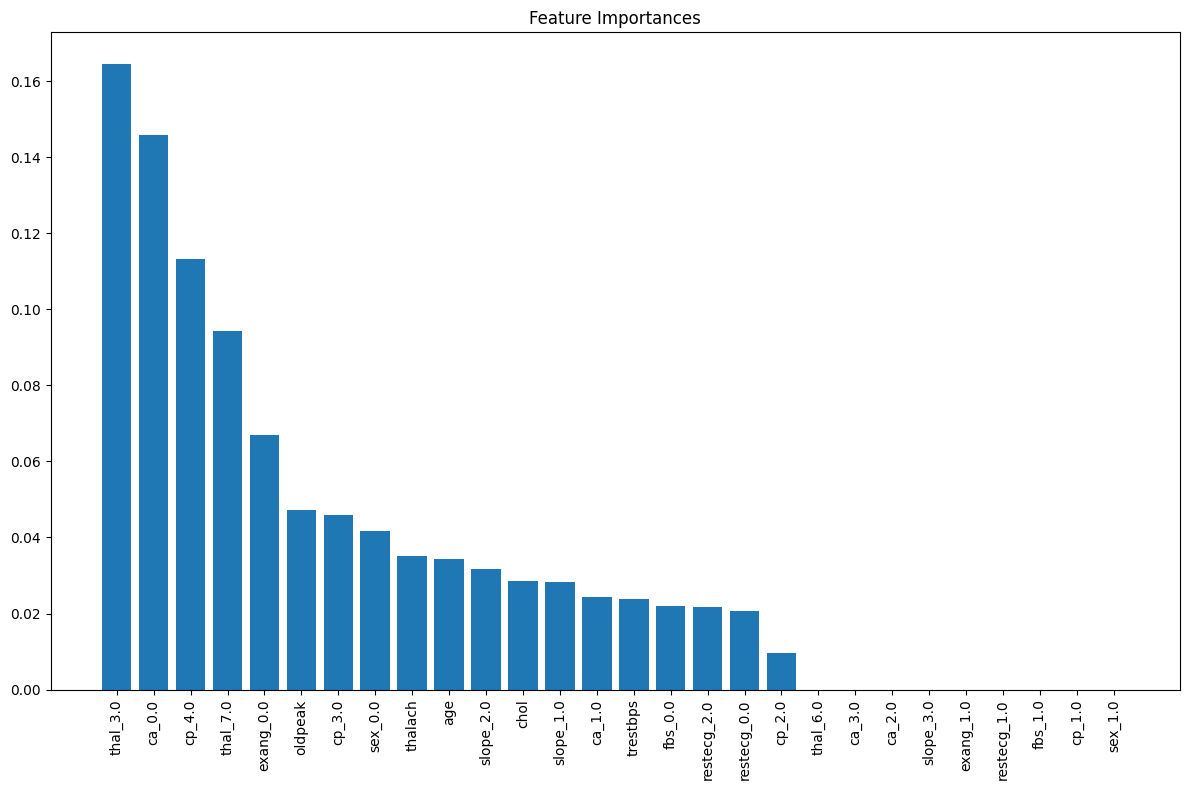

In [9]:
# Visualize feature importance 
if hasattr(model, 'feature_importances_'):
    # Get feature names from the preprocessing pipeline
    feature_names = []
    
    # Get the output feature names from the one-hot encoder
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(categorical_cols)
    
    # Get the numerical features that were passed through
    num_features = [col for col in X.columns if col not in categorical_cols]
    
    # Combine all feature names
    feature_names = list(cat_features) + list(num_features)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

### 5. Find errors in training prediction

In [10]:
print("\n5. Detecting errors in training data...")
errors_df, error_transactions, value_to_column = detect_errors(X_train, y_train, pipeline)

error_count = errors_df["error"].sum()
error_rate = error_count / len(errors_df) * 100
print(f"Found {error_count} errors in training data ({error_rate:.2f}%).")



5. Detecting errors in training data...
Found 4 errors in training data (1.69%).


### 6. Mine error patterns with association rules. this might take some time

In [11]:
print("\n6. Mining error patterns with association rules...")

# Start with a reasonable min_support value
min_support = 0.05

rules, value_to_column = mine_association_rules(
    error_transactions,
    min_support=min_support,
    min_confidence=0.4,
    min_lift=1.0,
    value_to_column=value_to_column,
)

print(f"Found {len(rules)} rules with min_support={min_support}")

# Sort rules by lift and confidence 
sorted_rules = rules.sort_values(by=["lift", "confidence"], ascending=[False, False])

# Display the top rules
top_n = 5
top_rules = sorted_rules.head(top_n)

# Convert rules to a more readable format
rule_dicts = prepare_rules_for_application(top_rules, value_to_column)

# Display top rules
print(f"\nTop {top_n} error patterns discovered:")
for i, rule in enumerate(rule_dicts):
    # Get confidence and lift
    confidence = rule["confidence"]
    lift = rule["lift"]
    
    # Get antecedent and consequent fields
    consequent_fields = rule.get("consequent_fields", [])
    antecedent_fields = [
        k
        for k in rule.keys()
        if k
        not in [
            "confidence",
            "lift",
            "support",
            "original_antecedents",
            "original_consequents",
            "consequent_fields",
        ]
        + consequent_fields
    ]
    
    condition_str = ", ".join([f"{feat}={rule[feat]}" for feat in antecedent_fields])
    if consequent_fields:
        consequent_str = ", ".join([f"{feat}={rule[feat]}" for feat in consequent_fields])
        print(f"Rule {i+1}: IF {condition_str} THEN {consequent_str} (conf={confidence:.2f}, lift={lift:.2f})")
    else:
        print(f"Rule {i+1}: IF {condition_str} THEN Error (conf={confidence:.2f}, lift={lift:.2f})")


6. Mining error patterns with association rules...
Found 6149644 rules with min_support=0.05

Top 5 error patterns discovered:
Rule 1: IF age=0 THEN chol=0 (conf=1.00, lift=4.00)
Rule 2: IF chol=0 THEN age=0 (conf=1.00, lift=4.00)
Rule 3: IF thalach=3 THEN age=0 (conf=1.00, lift=4.00)
Rule 4: IF age=0 THEN thalach=3 (conf=1.00, lift=4.00)
Rule 5: IF trestbps=3 THEN age=0 (conf=1.00, lift=4.00)


### 7. apply rules and evaluate

In [12]:
print("\n7. Applying error correction rules to test data...")
y_pred_corrected = predict_with_rules(pipeline, X_test, rule_dicts)

# 8. Evaluate corrected predictions
corrected_accuracy = accuracy_score(y_test, y_pred_corrected)
corrected_f1 = f1_score(y_test, y_pred_corrected)
corrected_auc = roc_auc_score(y_test, y_pred_corrected)

print("\n8. Performance after applying error correction rules:")
print(f"Original Accuracy: {test_accuracy:.4f}")
print(f"Corrected Accuracy: {corrected_accuracy:.4f} ({(corrected_accuracy-test_accuracy)*100:+.2f}%)")
print(f"Original F1 Score: {test_f1:.4f}")
print(f"Corrected F1 Score: {corrected_f1:.4f} ({(corrected_f1-test_f1)*100:+.2f}%)")
print(f"Original ROC AUC: {test_auc:.4f}")
print(f"Corrected ROC AUC: {corrected_auc:.4f} ({(corrected_auc-test_auc)*100:+.2f}%)")

# 9. Count errors fixed vs introduced
errors_fixed = sum((y_test_pred != y_test) & (y_pred_corrected == y_test))
errors_introduced = sum((y_test_pred == y_test) & (y_pred_corrected != y_test))

print(f"\n9. Error analysis:")
print(f"Errors fixed: {errors_fixed}")
print(f"Errors introduced: {errors_introduced}")
print(f"Net improvement: {errors_fixed - errors_introduced} samples")



7. Applying error correction rules to test data...

Total rows where rules were applied: 36 out of 60
Rule 1 matched and flipped 16 predictions
Rule 2 matched and flipped 10 predictions
Rule 3 matched and flipped 4 predictions
Rule 5 matched and flipped 6 predictions

8. Performance after applying error correction rules:
Original Accuracy: 0.8333
Corrected Accuracy: 0.4000 (-43.33%)
Original F1 Score: 0.8077
Corrected F1 Score: 0.4706 (-33.71%)
Original ROC AUC: 0.8403
Corrected ROC AUC: 0.4444 (-39.58%)

9. Error analysis:
Errors fixed: 5
Errors introduced: 31
Net improvement: -26 samples


### 10. Visualize before/after comparison

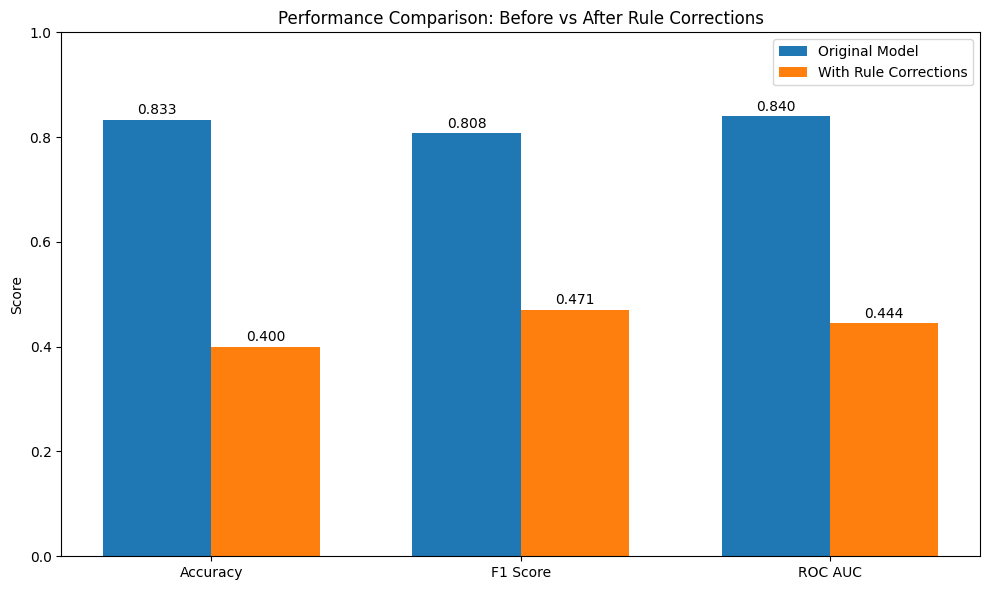

In [13]:
metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
original_values = [test_accuracy, test_f1, test_auc]
corrected_values = [corrected_accuracy, corrected_f1, corrected_auc]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, original_values, width, label='Original Model')
plt.bar(x + width/2, corrected_values, width, label='With Rule Corrections')

plt.ylabel('Score')
plt.title('Performance Comparison: Before vs After Rule Corrections')
plt.xticks(x, metrics)
plt.ylim(0, 1.0)

for i, v in enumerate(original_values):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    
for i, v in enumerate(corrected_values):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

### 11. Summary of our approach

In [14]:
print(f"1. The original model achieved {test_accuracy:.2%} accuracy on the test set.")
print(f"2. We discovered {len(rules)} rules that identified patterns in prediction errors.")
print(f"3. By applying the top {top_n} rules to correct predictions, we:")

print(f"Fixed {errors_fixed} errors while introducing {errors_introduced} new ones")
print(f"overall accuracy changed to {corrected_accuracy:.2%} ({(corrected_accuracy-test_accuracy)*100:.2f}%)")

print("\nTop patterns that explains errors:")
for i, rule in enumerate(rule_dicts):
    # Get confidence and lift
    confidence = rule["confidence"]
    lift = rule["lift"]
    
    # Get antecedent fields
    antecedent_fields = [
        k for k in rule.keys()
        if k not in [
            "confidence", "lift", "support", 
            "original_antecedents", "original_consequents", "consequent_fields"
        ]
    ]
    
    condition_str = ", ".join([f"{feat}={rule[feat]}" for feat in antecedent_fields])
    print(f"{i+1}: {condition_str}")


1. The original model achieved 83.33% accuracy on the test set.
2. We discovered 6149644 rules that identified patterns in prediction errors.
3. By applying the top 5 rules to correct predictions, we:
Fixed 5 errors while introducing 31 new ones
overall accuracy changed to 40.00% (-43.33%)

Top patterns that explains errors:
1: age=0, chol=0
2: chol=0, age=0
3: thalach=3, age=0
4: age=0, thalach=3
5: trestbps=3, age=0


even though our approach failed, we do believe that it has potential and can be improved. we discuss it more in the pdf

### 12. Classic Error Analysis vs. Error Rule Mining Approach


12. Comparing Classic Error Analysis with Error Rule Mining:

Classic Error Analysis:
--------------------------------------------------
1. Feature Correlation with Prediction Errors:
          Error_Correlation  Abs_Correlation
trestbps           0.220602         0.220602
age                0.203485         0.203485
chol               0.093990         0.093990
oldpeak            0.036895         0.036895
thalach           -0.010901         0.010901


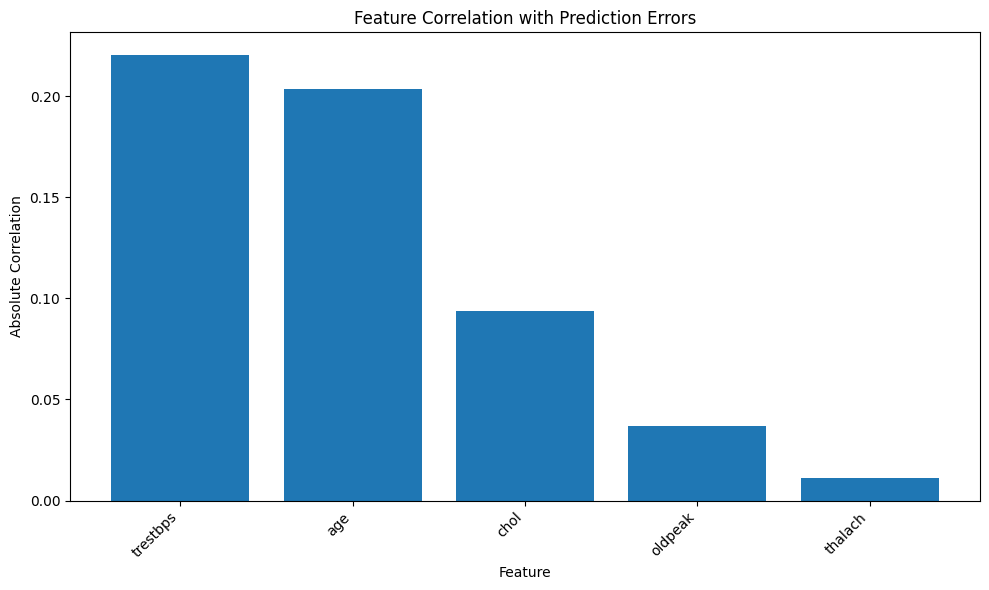

In [ ]:
print("\n12. Comparing Classic Error Analysis with Error Rule Mining:")
print("="*80)

# First, let's perform some classic error analysis techniques
print("\nClassic Error Analysis:")
print("-"*50)

# 1. Error correlation with features
print("1. Feature Correlation with Prediction Errors:")

# For classification problems, we need to adjust the approach
feature_names = X_test.columns
# Create a binary error indicator (1 if error, 0 if correct)
error_indicator = (y_test != y_test_pred).astype(int)

# Initialize a DataFrame to store correlations
feature_error_corr = pd.DataFrame()

# Calculate point-biserial correlation between each feature and error indicator
for feature in feature_names:
    # For categorical features, we can't directly calculate correlation
    # So we'll convert to numeric if needed
    if X_test[feature].dtype == 'object':
        # Skip categorical features or encode them
        continue
    
    feature_error_corr.loc[feature, 'Error_Correlation'] = np.corrcoef(X_test[feature], error_indicator)[0,1]

# Get absolute correlation values
feature_error_corr['Abs_Correlation'] = abs(feature_error_corr['Error_Correlation'])
feature_error_corr = feature_error_corr.sort_values('Abs_Correlation', ascending=False)

print(feature_error_corr)

# Visualize the correlations
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_error_corr)), feature_error_corr['Abs_Correlation'])
plt.xticks(range(len(feature_error_corr)), feature_error_corr.index, rotation=45, ha='right')
plt.title('Feature Correlation with Prediction Errors')
plt.xlabel('Feature')
plt.ylabel('Absolute Correlation')
plt.tight_layout()
plt.show()



as we can see from the graph aboove that uses more classic error analysis we see that the features that correlates with the errors are the same features in our rules. which shows that our rules indeed captured pattern that can cause error.

**our rules:**

1: chol=0, age=0

2: thalach=3, age=0

3: trestbps=3, age=0

Now if we want to try and improve the model we will choose the most problematic feature and try to work with it untill we improve, this is a manual job compared to our automatic approach